# Inception V4

In [1]:
name = 'inceptionv4_gender_'

In [2]:
# Import needed libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D, Normalization
from tensorflow.keras.models import Model

In [3]:
# Check Tensorflow version
print('Tensorflow version: ',tf.__version__)
# Check if GPU is being used
print('GPU available: ', tf.config.list_physical_devices('GPU'))
# If a GPU is being used, check that it's not being used by another process as well
if tf.config.list_physical_devices('GPU'):
  print("GPU usage: ", tf.config.experimental.get_memory_info('GPU:0'))

Tensorflow version:  2.10.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU usage:  {'current': 0, 'peak': 0}


## Load the data

In [4]:
def process_image(path_gender, label):
    # Desired size
    size = 250
    path, gender = path_gender
    # Get the image
    img = tf.io.read_file(path)
    # Decode the PNG
    img = tf.image.decode_png(img)
    # Resize image
    img = tf.image.resize(img, (size, size))
    # Reshape image (this is not necessary but I do it so that I don't need to be modifying the shape in the input layer)
    img = tf.reshape(img, [size, size, 1])
    # Cast image to float32
    img = tf.cast(img, tf.float32)
    # Normalize image
    img = img/255.0

    return (img, gender), label

In [30]:
def get_data(csv_path, images_folder_path, id_col, label_col, gender_col):
    df = pd.read_csv(csv_path)
    paths = [images_folder_path + '/' + str(id) + '.png' for id in df[id_col].tolist()]
    labels = df[label_col].tolist()
    gender = [0 if (str(g)=="False" or str(g)=="FALSE") else 1 for g in df[gender_col].tolist()] # male 1, female 0
    return paths, labels, gender

In [6]:
# Dataset used
ds = 'preprocessed_r250p'

# INPUT PIPELINE
#------------------------
# Training set
# ------------------------
train_paths, train_labels, train_gender = get_data( csv_path='./data/pre_processed/training/train.csv',
                                                images_folder_path='./data/pre_processed/training/{}'.format(ds),
                                                id_col='id',
                                                label_col='boneage',
                                                gender_col='male')

train_dataset = tf.data.Dataset.from_tensor_slices(((train_paths,train_gender),train_labels)).map(process_image)
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(8)

#------------------------
#Validation set
# ------------------------
validation_paths, validation_labels, validation_gender = get_data(
                                                csv_path='./data/pre_processed/validation/validation.csv',
                                                images_folder_path='./data/pre_processed/validation/{}'.format(ds),
                                                id_col='Image ID',
                                                label_col='Bone Age (months)',
                                                gender_col='male')
validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_paths,validation_gender),validation_labels)).map(process_image).batch(8)

In [7]:
# for (img,gender), label in train_dataset:
#     print(gender)
#     break

## Instantiate the model

Useful functions

In [8]:
#-----------------------------------------------
# Convolution + Batch Normalization + Activation
#-----------------------------------------------
# conv_bn_act block
#-----------------------------------------------
def conv_bn_act(X_input, filters, kernel_size, strides, padding='same', activation=None, name=None):

    # Add the layers
    x = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, name='conv_'+name)(X_input)
    x  = BatchNormalization(name='bn'+name)(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x

Inception blocks

In [9]:
#-----------------------------------------------
# STEM BLOCK
#-----------------------------------------------
# stem_block
#-----------------------------------------------
def stem_block(X_input):

    # First conv
    X = conv_bn_act(X_input, filters = 32, kernel_size = (3, 3), strides = (2, 2),
                    padding = 'valid', activation='relu', name = 'stem_1th')
    # Second conv
    X = conv_bn_act(X, filters = 32, kernel_size = (3, 3), strides = (1, 1),
                    padding = 'valid', activation='relu', name = 'stem_2nd')
    # Third conv
    X = conv_bn_act(X, filters = 64, kernel_size = (3, 3), strides = (1, 1),
                  padding = 'same', activation='relu', name =  'stem_3rd')
    #-----------------------------------------------
    # BRANCH SPLIT
    #-----------------------------------------------
    # First branch: max pooling
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_1stbranch_1')(X)
    # Second branch: conv
    branch2 = conv_bn_act(X, filters = 96, kernel_size = (3, 3), strides = (2, 2),
                          padding = 'valid', activation='relu', name = 'stem_1stbranch_2')

    #-----------------------------------------------
    # MERGE BRANCHES
    #-----------------------------------------------
    # Concatenate (1) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    #-----------------------------------------------
    # BRANCH SPLIT
    #-----------------------------------------------
    # First branch: 2 convs
    branch1 = conv_bn_act(X, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_1_1')
    branch1 = conv_bn_act(branch1, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'valid', activation='relu',
                        name = 'stem_2ndbranch_1_2')

    # Second branch: 4 convs
    branch2 = conv_bn_act(X, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_1')
    branch2 = conv_bn_act(branch2, filters = 64, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_2')
    branch2 = conv_bn_act(branch2, filters = 64, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_3')
    branch2 = conv_bn_act(branch2, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'valid', activation='relu',
                        name = 'stem_2ndbranch_2_4')

    #-----------------------------------------------
    # MERGE BRANCHES
    #-----------------------------------------------
    # Concatenate (2) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    #-----------------------------------------------
    # BRANCH SPLIT
    #-----------------------------------------------
    # First branch: conv
    branch1 = conv_bn_act(X, filters = 192, kernel_size = (3, 3), strides = (2, 2),
                          padding = 'valid', activation='relu', name = 'stem_3rdbranch_1')
    # Second branch: max pooling
    branch2 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_3rdbranch_2')(X)

    #-----------------------------------------------
    # MERGE BRANCHES
    #-----------------------------------------------
    # Concatenate (3) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    return X

In [10]:
#-----------------------------------------------
# INCEPTION A BLOCK
#-----------------------------------------------
# inception_a_block
#-----------------------------------------------
def inception_a_block(X_input, base_name):

    #-----------------------------------------------
    # BRANCH SPLIT
    #-----------------------------------------------
    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                               padding = 'same', name = base_name + 'ia_branch_1_1')(X_input)
    branch1 = conv_bn_act(branch1, filters = 96, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ia_branch_1_2')
    # Branch 2
    branch2 = conv_bn_act(X_input, filters = 96, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ia_branch_2_1')
    # Branch 3
    branch3 = conv_bn_act(X_input, filters = 64, kernel_size = (1, 1),strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ia_branch_3_1')
    branch3 = conv_bn_act(branch3, filters = 96, kernel_size = (3, 3), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ia_branch_3_2')
    # Branch 4
    branch4 = conv_bn_act(X_input, filters = 64, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ia_branch_4_1')
    branch4 = conv_bn_act(branch4, filters = 96, kernel_size = (3, 3), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ia_branch_4_2')
    branch4 = conv_bn_act(branch4, filters = 96, kernel_size = (3, 3), strides = (1, 1),
                          padding = 'same', activation='relu',  name = base_name + 'ia_branch_4_3')

    #-----------------------------------------------
    # MERGE BRANCHES
    #-----------------------------------------------
    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)

    return X

In [11]:
#-----------------------------------------------
# INCEPTION B BLOCK
#-----------------------------------------------
# inception_b_block
#-----------------------------------------------
def inception_b_block(X_input, base_name):

    #-----------------------------------------------
    # BRANCH SPLIT
    #-----------------------------------------------
    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ib_branch_1_1')(X_input)
    branch1 = conv_bn_act(branch1, filters = 128, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_1_2')
    # Branch 2
    branch2 = conv_bn_act(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_2_1')
    # Branch 3
    branch3 = conv_bn_act(X_input, filters = 192, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ib_branch_3_1')
    branch3 = conv_bn_act(branch3, filters = 224, kernel_size = (1, 7), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ib_branch_3_2')
    branch3 = conv_bn_act(branch3, filters = 256, kernel_size = (7, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ib_branch_3_3')

    # Branch 4
    branch4 = conv_bn_act(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_1')
    branch4 = conv_bn_act(branch4, filters = 192, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_2')
    branch4 = conv_bn_act(branch4, filters = 224, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_3')
    branch4 = conv_bn_act(branch4, filters = 224, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_4')
    branch4 = conv_bn_act(branch4, filters = 256, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_5')

    #-----------------------------------------------
    # MERGE BRANCHES
    #-----------------------------------------------
    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)

    return X

In [12]:
#-----------------------------------------------
# INCEPTION C BLOCK
#-----------------------------------------------
# inception_c_block
#-----------------------------------------------
def inception_c_block(X_input, base_name):

    #-----------------------------------------------
    # BRANCH SPLIT
    #-----------------------------------------------

    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ic_branch_1_1')(X_input)
    branch1 = conv_bn_act(branch1, filters = 256, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ic_branch_1_2')

    # Branch 2
    branch2 = conv_bn_act(X_input, filters = 256, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ic_branch_2_1')

    # Branch 3
    branch3 = conv_bn_act(X_input, filters = 384, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ic_branch_3_1')
    branch3_1 = conv_bn_act(branch3, filters = 256, kernel_size = (1, 3), strides = (1, 1),
                            padding = 'same', activation='relu', name = base_name + 'ic_branch_3_2')
    branch3_2 = conv_bn_act(branch3, filters = 256, kernel_size = (3, 1), strides = (1, 1),
                            padding = 'same', activation='relu', name = base_name + 'ic_branch_3_3')

    # Branch 4
    branch4 = conv_bn_act(X_input, filters = 384, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ic_branch_4_1')
    branch4 = conv_bn_act(branch4, filters = 448, kernel_size = (1, 3), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ic_branch_4_2')
    branch4 = conv_bn_act(branch4, filters = 512, kernel_size = (3, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ic_branch_4_3')
    branch4_1 = conv_bn_act(branch4, filters = 256, kernel_size = (3, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = base_name + 'ic_branch_4_4')
    branch4_2 = conv_bn_act(branch4, filters = 256, kernel_size = (1, 3), strides = (1, 1),
                            padding = 'same', activation='relu', name = base_name + 'ic_branch_4_5')

    #-----------------------------------------------
    # MERGE BRANCHES
    #-----------------------------------------------
    # Concatenate branch1, branch2, branch3_1, branch3_2, branch4_1 and branch4_2 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3_1, branch3_2, branch4_1, branch4_2], axis=3)

    return X

In [13]:
#-----------------------------------------------
# REDUCTION A BLOCK
#-----------------------------------------------
# reduction_a_block
#-----------------------------------------------
def reduction_a_block(X_input):
    #-----------------------------------------------
    # BRANCH SPLIT
    #-----------------------------------------------
    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'ra_branch_1_1')(X_input)
    # Branch 2
    branch2 = conv_bn_act(X_input, filters = 384, kernel_size = (3, 3), strides = (2, 2),
                          padding = 'valid', activation='relu', name = 'ra_branch_2_1')
    # Branch 3
    branch3 = conv_bn_act(X_input, filters = 192, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = 'ra_branch_3_1')
    branch3 = conv_bn_act(branch3, filters = 224, kernel_size = (3, 3), strides = (1, 1),
                          padding = 'same', activation='relu', name = 'ra_branch_3_2')
    branch3 = conv_bn_act(branch3, filters = 256, kernel_size = (3, 3), strides = (2, 2),
                          padding = 'valid', activation='relu',name = 'ra_branch_3_3')

    #-----------------------------------------------
    # MERGE BRANCHES
    #-----------------------------------------------
    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3], axis=3)

    return X

In [14]:
#-----------------------------------------------
# REDUCTION B BLOCK
#-----------------------------------------------
# reduction_b_block
#-----------------------------------------------
def reduction_b_block(X_input):
    #-----------------------------------------------
    # BRANCH SPLIT
    #-----------------------------------------------
    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'rb_branch_1_1')(X_input)

    # Branch 2
    branch2 = conv_bn_act(X_input, filters = 192, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = 'rb_branch_2_1')
    branch2 = conv_bn_act(branch2, filters = 192, kernel_size = (3, 3), strides = (2, 2),
                          padding = 'valid', activation='relu', name = 'rb_branch_2_2')

    # Branch 3
    branch3 = conv_bn_act(X_input, filters = 256, kernel_size = (1, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = 'rb_branch_3_1')
    branch3 = conv_bn_act(branch3, filters = 256, kernel_size = (1, 7), strides = (1, 1),
                          padding = 'same', activation='relu', name = 'rb_branch_3_2')
    branch3 = conv_bn_act(branch3, filters = 320, kernel_size = (7, 1), strides = (1, 1),
                          padding = 'same', activation='relu', name = 'rb_branch_3_3')
    branch3 = conv_bn_act(branch3, filters = 320, kernel_size = (3, 3), strides = (2, 2),
                          padding = 'valid', activation='relu', name = 'rb_branch_3_4')

    #-----------------------------------------------
    # MERGE BRANCHES
    #-----------------------------------------------
    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3], axis=3)

    return X

Network construction

In [15]:
# FUNCTION: Inception-v4

def Inceptionv4(input_shape):

    # Define the input as a tensor with shape input_shape (1 line)
    X_input = Input(shape=input_shape)

    # Call the above functions for the stem, inception-a, reduction-a, inception-b, reduction-b and inception-c blocks
    X = stem_block(X_input)

    # Four Inception A blocks
    X = inception_a_block(X, 'a1')
    X = inception_a_block(X, 'a2')
    X = inception_a_block(X, 'a3')
    X = inception_a_block(X, 'a4')

    # Reduction A block
    X = reduction_a_block(X)

    # Seven Inception B blocks
    X = inception_b_block(X, 'b1')
    X = inception_b_block(X, 'b2')
    X = inception_b_block(X, 'b3')
    X = inception_b_block(X, 'b4')
    X = inception_b_block(X, 'b5')
    X = inception_b_block(X, 'b6')
    X = inception_b_block(X, 'b7')

    # Reduction B block
    X = reduction_b_block(X)

    # Three Inception C blocks
    X = inception_c_block(X, 'c1')
    X = inception_c_block(X, 'c2')
    X = inception_c_block(X, 'c3')

    # AVGPOOL (1 line). Use "X = AveragePooling2D(...)(X)"
    kernel_pooling = X.get_shape()[1:3]
    X = AveragePooling2D(kernel_pooling, name='avg_pool')(X)
    X = Flatten()(X)

    # Gender branch
    input_gender = Input(shape=(1,))
    Y = Dense(100, activation='relu')(input_gender)

    # Concatenate the two layers
    z = tf.keras.layers.concatenate([X, Y])
    z = Dense(100, activation='relu')(z)
    z = Dense(100, activation='relu')(z)
    z = Dense(1)(z)

    # Create model
    model = Model(inputs=[X_input, input_gender], outputs = z, name='Inceptionv4')

    return model

In [16]:
model = Inceptionv4(input_shape = (250, 250, 1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [17]:
model.summary()

Model: "Inceptionv4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_stem_1th (Conv2D)         (None, 124, 124, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bnstem_1th (BatchNormalization  (None, 124, 124, 32  128        ['conv_stem_1th[0][0]']          
 )                              )                                                       

In [18]:
# Experiment tracking with tensorboard
import time
experiment_name = "{}_{}_{}".format(name,ds,int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(experiment_name))

In [19]:
# To make that the learning rate decreases
def schedule(epoch, lr):
    if epoch>=60:
        return 0.0001
    return 0.001
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

## Training ("fit") the model

In [20]:
# Fit the model
r = model.fit(train_dataset, validation_data=validation_dataset, epochs=75, callbacks=[tensorboard, scheduler])

Epoch 1/75
1577/1577 [==============================] - 530s 320ms/step - loss: 1830.1350 - root_mean_squared_error: 42.7801 - val_loss: 1810.6453 - val_root_mean_squared_error: 42.5517 - lr: 0.0010
Epoch 2/75
1577/1577 [==============================] - 504s 317ms/step - loss: 1643.9067 - root_mean_squared_error: 40.5451 - val_loss: 3274.1038 - val_root_mean_squared_error: 57.2198 - lr: 0.0010
Epoch 3/75
1577/1577 [==============================] - 524s 330ms/step - loss: 1009.3229 - root_mean_squared_error: 31.7698 - val_loss: 2954.8450 - val_root_mean_squared_error: 54.3585 - lr: 0.0010
Epoch 4/75
1577/1577 [==============================] - 492s 310ms/step - loss: 445.4388 - root_mean_squared_error: 21.1054 - val_loss: 2035.8370 - val_root_mean_squared_error: 45.1203 - lr: 0.0010
Epoch 5/75
1577/1577 [==============================] - 492s 310ms/step - loss: 353.9818 - root_mean_squared_error: 18.8144 - val_loss: 304.4895 - val_root_mean_squared_error: 17.4496 - lr: 0.0010
Epoch 6/

## Save the model

In [21]:
# Let's now save our model to a file
model.save('./models/{}.h5'.format(experiment_name))

## Make predictions

In [22]:
# Load the model
model = tf.keras.models.load_model('./models/{}.h5'.format(experiment_name))
model.evaluate(validation_dataset)

179/179 [==============================] - 22s 112ms/step - loss: 144.4991 - root_mean_squared_error: 12.0208


[144.4990997314453, 12.020777702331543]

In [23]:
p_test = model.predict(validation_dataset).reshape(-1)

179/179 [==============================] - 22s 114ms/step


Mean absolute error: 8.816082985861259


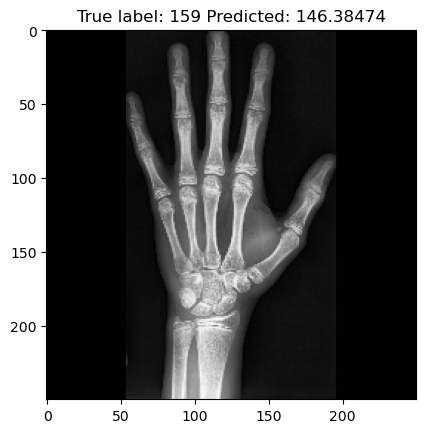

In [28]:
# Show some misclassified examples
y_test = np.array([label.numpy() for (img,gender), label in validation_dataset.unbatch()])
x_test = np.array([img.numpy() for (img,gender), label in validation_dataset.unbatch()])
difference = np.abs(np.subtract(y_test, p_test))
mae = np.mean(difference)
print("Mean absolute error: "+str(mae))
misclassified_idx = np.where(difference>4)
#print(len(misclassified_idx[0]))
i = np.random.choice(misclassified_idx[0])
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], p_test[i]));